In [ ]:
import os
import json
import numpy as np

import trimesh
from PIL import Image

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import open_clip

# CLIP config
CLIP_BACKBONE = "ViT-B-16"
CLIP_CHECKPOINT = "datacomp_xl_s13b_b90k"
CLIP_OUTPUT_SIZE = 512

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


/home/atuin/v123be/v123be16/software/private/conda/envs/sam3d-objects/lib/python3.11/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Using device: cuda


In [ ]:
ply_path = "/home/hpc/v123be/v123be16/sam-3d-objects/notebook/gaussians/single/chair.ply"
rgb_path = "/home/hpc/v123be/v123be16/sam-3d-objects/notebook/chair/image.jpg"
mask_path = "/home/hpc/v123be/v123be16/sam-3d-objects/notebook/chair/0.png"
cam_json_path = "/home/hpc/v123be/v123be16/sam-3d-objects/notebook/chair/transforms.json"


In [ ]:

def load_point_cloud_ply(path):
    mesh = trimesh.load(path)
    if hasattr(mesh, "vertices"):
        pts = np.asarray(mesh.vertices, dtype=np.float32)
    elif hasattr(mesh, "points"):
        pts = np.asarray(mesh.points, dtype=np.float32)
    else:
        raise ValueError(f"Unknown trimesh object type: {type(mesh)}")

    print(f"Loaded point cloud from {path}: {pts.shape}")
    print("Min coords:", pts.min(axis=0))
    print("Max coords:", pts.max(axis=0))
    return pts

points = load_point_cloud_ply(ply_path)


Loaded point cloud from /home/hpc/v123be/v123be16/sam-3d-objects/notebook/gaussians/single/chair.ply: (284544, 3)
Min coords: [-0.2984029  -0.3328535  -0.49904558]
Max coords: [0.3004129  0.32970417 0.49858648]


In [ ]:

def load_rgb_and_mask(rgb_path, mask_path):
    rgb = np.array(Image.open(rgb_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"))  # grayscale
    mask_bin = (mask > 0).astype(np.uint8)

    print(f"Loaded RGB {rgb.shape} and mask {mask.shape}")
    return rgb, mask_bin

rgb, mask = load_rgb_and_mask(rgb_path, mask_path)
H, W, _ = rgb.shape
print("H, W:", H, W)


Loaded RGB (640, 480, 3) and mask (640, 480)
H, W: 640 480


In [ ]:
#load intrinsics (K) + raw transform_matrix (T_raw) from NeRF-style Transform.json

def load_intrinsics_and_raw_transform(json_path, target_file_path=None):
    with open(json_path, "r") as f:
        meta = json.load(f)

    w = float(meta["w"])
    h = float(meta["h"])
    print(f"JSON image size: w={w}, h={h}")

    fx = float(meta.get("fl_x", meta.get("fl_y")))
    fy = float(meta.get("fl_y", meta.get("fl_x")))
    cx = float(meta.get("cx", w / 2.0))
    cy = float(meta.get("cy", h / 2.0))

    K = np.array([
        [fx, 0.0, cx],
        [0.0, fy, cy],
        [0.0, 0.0, 1.0]
    ], dtype=np.float32)

    frames = meta["frames"]

    # choose frame whose file_path matches rgb_path basename
    if target_file_path is not None:
        basename = os.path.basename(target_file_path)
        chosen = None
        for fr in frames:
            if os.path.basename(fr["file_path"]) == basename:
                chosen = fr
                break
        if chosen is None:
            raise RuntimeError(f"No frame with file_path ending in {basename}")
        frame_idx = frames.index(chosen)
    else:
        chosen = frames[0]
        frame_idx = 0

    print(f"Using frame index: {frame_idx}, file_path: {chosen['file_path']}")
    T_raw = np.array(chosen["transform_matrix"], dtype=np.float32)

    print("K:\n", K)
    print("T_raw:\n", T_raw)
    return K, T_raw

K, T_raw = load_intrinsics_and_raw_transform(cam_json_path, target_file_path=rgb_path)


JSON image size: w=480.0, h=640.0
Using frame index: 0, file_path: /home/hpc/v123be/v123be16/sam-3d-objects/notebook/chair/image.jpg
K:
 [[529.774     0.      234.89989]
 [  0.      529.774   324.41302]
 [  0.        0.        1.     ]]
T_raw:
 [[-0.2769532  -0.50484157  0.8175769   3.6888022 ]
 [ 0.9088345  -0.41386384  0.05231183  0.27870032]
 [ 0.31195632  0.75753     0.57343835  2.151738  ]
 [ 0.          0.          0.          1.        ]]


In [6]:
# Cell 6: projection & choosing camera convention

def project_points(points, K, w2c):
    """
    points: (N, 3)
    K: (3, 3)
    w2c: (4, 4)
    Returns:
        pixels: (N, 2)
        depths: (N,)
    """
    N = points.shape[0]
    pts_h = np.hstack([points, np.ones((N, 1), dtype=np.float32)])  # N×4
    pts_cam = (w2c @ pts_h.T).T                                      # N×4
    X, Y, Z = pts_cam[:,0], pts_cam[:,1], pts_cam[:,2]

    eps = 1e-6
    Z_safe = np.where(Z == 0, eps, Z)
    x = X / Z_safe
    y = Y / Z_safe

    fx, fy = K[0,0], K[1,1]
    cx, cy = K[0,2], K[1,2]
    u = fx * x + cx
    v = fy * y + cy

    pixels = np.stack([u, v], axis=-1)
    depths = Z
    return pixels.astype(np.float32), depths.astype(np.float32)

def choose_w2c(points, K, T_raw):
    T_inv = np.linalg.inv(T_raw).astype(np.float32)

    pix1, z1 = project_points(points, K, T_raw)
    pix2, z2 = project_points(points, K, T_inv)

    c1 = (z1 > 0).sum()
    c2 = (z2 > 0).sum()

    print("Points in front: T_raw =", c1, ", inv(T_raw) =", c2)
    if c2 > c1:
        print("=> Using inv(T_raw) as w2c")
        return T_inv
    else:
        print("=> Using T_raw as w2c")
        return T_raw

w2c = choose_w2c(points, K, T_raw)

pixels_raw, depths = project_points(points, K, w2c)
print("Raw u range:", pixels_raw[:,0].min(), pixels_raw[:,0].max())
print("Raw v range:", pixels_raw[:,1].min(), pixels_raw[:,1].max())
print("Points in front (Z>0):", (depths > 0).sum())


Points in front: T_raw = 284544 , inv(T_raw) = 0
=> Using T_raw as w2c
Raw u range: 990.25134 1458.7878
Raw v range: 299.30954 526.2735
Points in front (Z>0): 284544


In [ ]:
#align projected points to mask bounding box

# mask bbox
ys_mask, xs_mask = np.where(mask > 0)
x_min_m, x_max_m = xs_mask.min(), xs_mask.max()
y_min_m, y_max_m = ys_mask.min(), ys_mask.max()
print("Mask bbox x:", x_min_m, x_max_m)
print("Mask bbox y:", y_min_m, y_max_m)

# projected bbox (only Z>0)
front_idx = depths > 0
u_raw = pixels_raw[front_idx, 0]
v_raw = pixels_raw[front_idx, 1]
u_min_p, u_max_p = u_raw.min(), u_raw.max()
v_min_p, v_max_p = v_raw.min(), v_raw.max()
print("Proj bbox u:", u_min_p, u_max_p)
print("Proj bbox v:", v_min_p, v_max_p)



# scales for x and y
# du = max(u_max_p - u_min_p, 1e-6)
# dv = max(v_max_p - v_min_p, 1e-6)
# mask_w = max(x_max_m - x_min_m, 1e-6)
# mask_h = max(y_max_m - y_min_m, 1e-6)

# scale_x = mask_w / du
# scale_y = mask_h / dv
# scale   = min(scale_x, scale_y)   # uniform

# shift_x = x_min_m - u_min_p * scale
# shift_y = y_min_m - v_min_p * scale

# aligned_u = pixels_raw[:,0] * scale + shift_x
# aligned_v = pixels_raw[:,1] * scale + shift_y




du = u_max_p - u_min_p
dv = v_max_p - v_min_p
mask_w = x_max_m - x_min_m
mask_h = y_max_m - y_min_m

scale_u = mask_w / du
scale_v = mask_h / dv        # ⬅️ potentially different scales
shift_u = x_min_m - u_min_p * scale_u
shift_v = y_min_m - v_min_p * scale_v

aligned_u = pixels_raw[:,0] * scale_u + shift_u
aligned_v = pixels_raw[:,1] * scale_v + shift_v






print("Aligned u range:", aligned_u[front_idx].min(), aligned_u[front_idx].max())
print("Aligned v range:", aligned_v[front_idx].min(), aligned_v[front_idx].max())


Mask bbox x: 119 422
Mask bbox y: 66 572
Proj bbox u: 990.25134 1458.7878
Proj bbox v: 299.30954 526.2735
Aligned u range: 119.0 422.0
Aligned v range: 66.0 572.0


In [ ]:
#visibile points based on RGB + mask

u_int = np.round(aligned_u).astype(int)
v_int = np.round(aligned_v).astype(int)

in_front = depths > 0
in_img = in_front & (u_int >= 0) & (u_int < W) & (v_int >= 0) & (v_int < H)
print("Step 2 - in image:", in_img.sum())

mask_bin = (mask > 0)
in_mask = np.zeros_like(in_img, dtype=bool)
valid_idx = np.where(in_img)[0]
for idx in valid_idx:
    if mask_bin[v_int[idx], u_int[idx]]:
        in_mask[idx] = True
print("Step 3 - on mask:", in_mask.sum())

patch_size = 56
half = patch_size // 2
patch_ok = in_mask & \
           (u_int >= half) & (u_int < W - half) & \
           (v_int >= half) & (v_int < H - half)
print("Step 4 - patch fits:", patch_ok.sum())

clip_ok = patch_ok
print("Total CLIP-eligible points:", clip_ok.sum())


Step 2 - in image: 284544
Step 3 - on mask: 151848
Step 4 - patch fits: 151848
Total CLIP-eligible points: 151848


In [ ]:
#CLIP feature extraction for mapped points

def compute_clip_features(points, rgb, mask_bin,
                                aligned_u, aligned_v, depths,
                                clip_ok,
                                patch_size=56,
                                batch_size=16,
                                device=DEVICE):
    H, W, _ = rgb.shape
    half = patch_size // 2
    N = points.shape[0]

    print("Loading CLIP model...")
    model, _, preprocess = open_clip.create_model_and_transforms(
        CLIP_BACKBONE,
        pretrained=CLIP_CHECKPOINT
    )
    model = model.to(device)
    model.eval()

    clip_features = torch.zeros(N, CLIP_OUTPUT_SIZE, device=device)
    is_visible = torch.zeros(N, dtype=torch.bool, device=device)

    u_int = np.round(aligned_u).astype(int)
    v_int = np.round(aligned_v).astype(int)

    with torch.no_grad(), torch.amp.autocast("cuda", enabled=device.startswith("cuda")):
        for start in range(0, N, batch_size):
            end = min(start + batch_size, N)
            patches = []
            idx_list = []

            for idx in range(start, end):
                if not clip_ok[idx]:
                    continue

                u_i = u_int[idx]
                v_i = v_int[idx]
                z   = depths[idx]

                # safety checks
                if z <= 0:
                    continue
                if not (0 <= u_i < W and 0 <= v_i < H):
                    continue
                if not mask_bin[v_i, u_i]:
                    continue
                if u_i < half or u_i >= W - half or v_i < half or v_i >= H - half:
                    continue

                patch = rgb[v_i-half:v_i+half, u_i-half:u_i+half, :]
                pil_patch = Image.fromarray(patch)
                clip_patch = preprocess(pil_patch)
                patches.append(clip_patch)
                idx_list.append(idx)

            if len(patches) == 0:
                continue

            batch_patches = torch.stack(patches, dim=0).to(device)
            feats = model.encode_image(batch_patches)

            for i, p_idx in enumerate(idx_list):
                clip_features[p_idx] = feats[i]
                is_visible[p_idx] = True

    return clip_features, is_visible

clip_features, is_visible = compute_clip_features(
    points,
    rgb,
    mask_bin,
    aligned_u,
    aligned_v,
    depths,
    clip_ok,
    patch_size=56,
    batch_size=16,
    device=DEVICE
)

print("CLIP features tensor shape:", clip_features.shape)
print("Visible points (for CLIP):", is_visible.sum().item())


Loading CLIP model...
CLIP features tensor shape: torch.Size([284544, 512])
Visible points (for CLIP): 151848


In [ ]:
#Save CLIP features and visibility mask

save_dir = "./clip_outputs"
os.makedirs(save_dir, exist_ok=True)

clip_features_path = os.path.join(save_dir, "clip_features.pt")
is_visible_path    = os.path.join(save_dir, "is_visible.pt")
points_path        = os.path.join(save_dir, "points.npy")
aligned_u_path     = os.path.join(save_dir, "aligned_u.npy")
aligned_v_path     = os.path.join(save_dir, "aligned_v.npy")

# Save torch tensors
torch.save(clip_features, clip_features_path)
torch.save(is_visible,    is_visible_path)

# Save numpy data
np.save(points_path, points)
np.save(aligned_u_path, aligned_u)
np.save(aligned_v_path, aligned_v)

print("Saved:")
print(" -", clip_features_path)
print(" -", is_visible_path)
print(" -", points_path)
print(" -", aligned_u_path)
print(" -", aligned_v_path)


Saved:
 - ./clip_outputs/clip_features.pt
 - ./clip_outputs/is_visible.pt
 - ./clip_outputs/points.npy
 - ./clip_outputs/aligned_u.npy
 - ./clip_outputs/aligned_v.npy


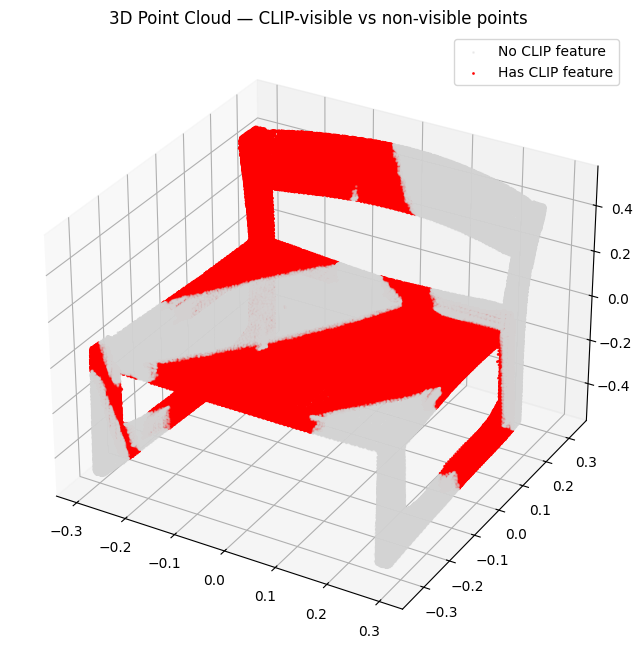

In [ ]:
#visualize 3D points with CLIP vs no-CLIP

def visualize_visible_points(points, is_visible, s=1, figsize=(8, 8)):
    if hasattr(is_visible, "cpu"):
        is_visible = is_visible.cpu().numpy()
    if hasattr(points, "cpu"):
        points = points.cpu().numpy()

    vis = is_visible
    non_vis = ~vis

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[non_vis, 0], points[non_vis, 1], points[non_vis, 2],
               s=s, c='lightgray', alpha=0.3, label="No CLIP feature")
    ax.scatter(points[vis, 0], points[vis, 1], points[vis, 2],
               s=s, c='red', alpha=0.9, label="Has CLIP feature")

    ax.set_title("3D Point Cloud — CLIP-visible vs non-visible points")
    ax.legend()
    plt.show()

visualize_visible_points(points, is_visible, s=1)


In [19]:
idxs = np.where(is_visible.cpu().numpy())[0]
print("Visible count:", len(idxs))

# check a random visible point
i = idxs[0]
print("CLIP feature norm:", torch.norm(clip_features[i]))


Visible count: 151848
CLIP feature norm: tensor(17.4700, device='cuda:0')


In [20]:
j = np.where(~is_visible.cpu().numpy())[0][0]
print("Non-visible norm:", torch.norm(clip_features[j]))


Non-visible norm: tensor(0., device='cuda:0')


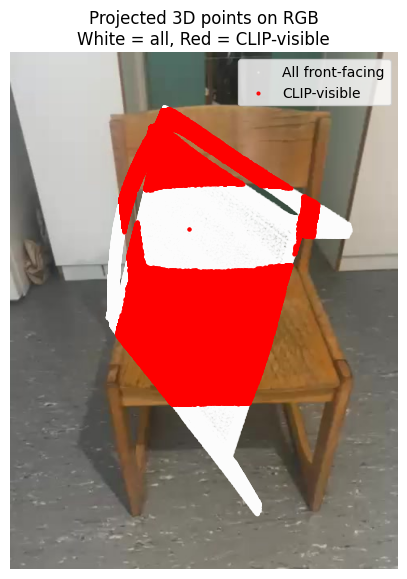

In [ ]:
#2D overlay of projections

plt.figure(figsize=(5, 8))
plt.imshow(rgb)
plt.axis("off")

# all front-facing points
plt.scatter(aligned_u[in_front], aligned_v[in_front], s=1, c='white', alpha=0.3, label="All front-facing")

# CLIP-visible points
plt.scatter(aligned_u[is_visible.cpu().numpy()], aligned_v[is_visible.cpu().numpy()],
            s=4, c='red', alpha=0.9, label="CLIP-visible")

plt.title("Projected 3D points on RGB\nWhite = all, Red = CLIP-visible")
plt.legend()
plt.show()
